In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# 대상 CSV 파일 리스트
csv_files = [
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_1_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_2_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_3_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_4_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_5_data.csv"),
]

# 저장할 폴더
save_dir = Path("./fixed_tsp_v2")
save_dir.mkdir(parents=True, exist_ok=True)

# 각 파일에서 TSP1, TSP2 추출하고 저장
saved = []
for i, f in enumerate(csv_files):
    try:
        df = pd.read_csv(f)
        TSP1 = df["TSP1"].values
        TSP2 = df["TSP2"].values
        np.save(save_dir / f"tsp1_ep{i}.npy", TSP1)
        np.save(save_dir / f"tsp2_ep{i}.npy", TSP2)
        saved.append({
            "episode": i,
            "tsp1_path": str(save_dir / f"tsp1_ep{i}.npy"),
            "tsp2_path": str(save_dir / f"tsp2_ep{i}.npy"),
            "source_csv": str(f)
        })
    except Exception as e:
        saved.append({
            "episode": i,
            "tsp1_path": None,
            "tsp2_path": None,
            "source_csv": str(f),
            "error": str(e)
        })

df_saved = pd.DataFrame(saved)
#import ace_tools as tools; tools.display_dataframe_to_user(name="고정 TSP 저장 결과", dataframe=df_saved)
print(df_saved)

   episode                  tsp1_path                  tsp2_path  \
0        0  fixed_tsp_v2\tsp1_ep0.npy  fixed_tsp_v2\tsp2_ep0.npy   
1        1  fixed_tsp_v2\tsp1_ep1.npy  fixed_tsp_v2\tsp2_ep1.npy   
2        2  fixed_tsp_v2\tsp1_ep2.npy  fixed_tsp_v2\tsp2_ep2.npy   
3        3  fixed_tsp_v2\tsp1_ep3.npy  fixed_tsp_v2\tsp2_ep3.npy   
4        4  fixed_tsp_v2\tsp1_ep4.npy  fixed_tsp_v2\tsp2_ep4.npy   

                                          source_csv  
0  C:\Users\User\TCLab\dataset\data_back7\PID2MPC...  
1  C:\Users\User\TCLab\dataset\data_back7\PID2MPC...  
2  C:\Users\User\TCLab\dataset\data_back7\PID2MPC...  
3  C:\Users\User\TCLab\dataset\data_back7\PID2MPC...  
4  C:\Users\User\TCLab\dataset\data_back7\PID2MPC...  


In [13]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import sys
import sys
from pathlib import Path

# 현재 작업 디렉토리 기준으로 src 경로 추가
sys.path.append(str(Path.cwd() / "src"))

# ──────────────────────────────────────────────
# 고정된 TSP 기반으로 IQL 성능 평가하는 함수
# ──────────────────────────────────────────────
def evaluate_iql_with_fixed_tsp(pt_path, tsp1_path, tsp2_path, scaler_path, dt=5.0, ambient=29.0, deterministic=True):
    from tclab import setup
    from src.util import torchify
    from src.policy import GaussianPolicy
    import torch
    from tqdm import trange

    Tsp1 = np.load(tsp1_path)
    Tsp2 = np.load(tsp2_path)
    steps = len(Tsp1)
    reward_scaler = joblib.load(scaler_path)

    obs_dim, act_dim = 4, 2
    policy = GaussianPolicy(obs_dim, act_dim, hidden_dim=256, n_hidden=2)
    full_state = torch.load(pt_path)
    policy_state = {k.replace("policy.", ""): v for k, v in full_state.items() if k.startswith("policy.")}
    policy.load_state_dict(policy_state)

    lab = setup(connected=False)
    env = lab(synced=False)
    env.T_amb = ambient
    env.Q1(0); env.Q2(0)
    env._T1 = env._T2 = ambient

    T1 = np.zeros(steps); T2 = np.zeros(steps)
    Q1 = np.zeros(steps); Q2 = np.zeros(steps)
    total_ret = e1 = e2 = over = under = 0.0

    for k in trange(steps, desc="eval_iql"):
        env.update(t=k * dt)
        T1[k], T2[k] = env.T1, env.T2
        obs = np.array([T1[k], T2[k], Tsp1[k], Tsp2[k]], dtype=np.float32)
        with torch.no_grad():
            act = policy.act(torchify(obs), deterministic=deterministic).cpu().numpy()
        Q1[k] = np.clip(act[0], 0, 100)
        Q2[k] = np.clip(act[1], 0, 100)
        env.Q1(Q1[k]); env.Q2(Q2[k])

        err1, err2 = Tsp1[k] - T1[k], Tsp2[k] - T2[k]
        raw_reward = -np.sqrt(err1**2 + err2**2)
        reward = reward_scaler.transform([[raw_reward]])[0][0]
        total_ret += reward
        e1 += abs(err1); e2 += abs(err2)
        over += max(0, -err1) + max(0, -err2)
        under += max(0, err1) + max(0, err2)

    return dict(E1=e1, E2=e2, Over=over, Under=under, total_return=total_ret)

# ──────────────────────────────────────────────
# 예시 실행 정보 (로컬에서 경로 지정 필요)
# ──────────────────────────────────────────────
pt_path = Path("C:/Users/User/TCLab/IQL/sam/tclab-mpc-iql/05-05-25_12.38.17_hrpy/best.pt")
scaler_path = Path("C:/Users/User/TCLab/dataset/outputs/first_reward.pkl")
tsp_dir = Path("C:/Users/User/TCLab/Data/fixed_tsp_v2")

results_iql = []
for i in range(5):
    tsp1 = tsp_dir / f"tsp1_ep{i}.npy"
    tsp2 = tsp_dir / f"tsp2_ep{i}.npy"
    result = evaluate_iql_with_fixed_tsp(pt_path, tsp1, tsp2, scaler_path)
    result["model"] = "IQL"
    result["episode"] = i
    results_iql.append(result)

df_iql = pd.DataFrame(results_iql)
print(df_iql)
#import ace_tools as tools; tools.display_dataframe_to_user(name="IQL Evaluation Results", dataframe=df_iql)


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1021.21it/s]


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1418.37it/s]


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1516.51it/s]


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1441.82it/s]


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1317.17it/s]

         E1         E2      Over      Under  total_return model  episode
0  999.0549  1886.9437  671.1944  2214.8042    -82.854862   IQL        0
1  267.3388  2355.0933  746.1260  1876.3061    -80.919859   IQL        1
2  635.0937   458.9506  247.3022   846.7421     96.511474   IQL        2
3  385.2577   222.1363   83.8512   523.5428    153.506740   IQL        3
4  137.9630  1982.9945  497.6567  1623.3008    -31.900622   IQL        4


In [14]:
def evaluate_iql_with_fixed_tsp(
    pt_path,
    tsp1_path,
    tsp2_path,
    scaler_path,
    dt=5.0,
    ambient=29.0,
    deterministic=True,
    save_dir: Path = None,  # 추가된 인자: rollout 저장 위치
    episode: int = 0,       # 저장 파일 이름에 쓸 에피소드 번호
):
    from tclab import setup
    from src.util import torchify
    from src.policy import GaussianPolicy
    import torch
    from tqdm import trange
    import csv
    import matplotlib.pyplot as plt

    Tsp1 = np.load(tsp1_path)
    Tsp2 = np.load(tsp2_path)
    steps = len(Tsp1)
    reward_scaler = joblib.load(scaler_path)

    obs_dim, act_dim = 4, 2
    policy = GaussianPolicy(obs_dim, act_dim, hidden_dim=256, n_hidden=2)
    full_state = torch.load(pt_path)
    policy_state = {k.replace("policy.", ""): v for k, v in full_state.items() if k.startswith("policy.")}
    policy.load_state_dict(policy_state)
    policy.eval()

    lab = setup(connected=False)
    env = lab(synced=False)
    env.T_amb = ambient
    env.Q1(0); env.Q2(0)
    env._T1 = env._T2 = ambient

    T1 = np.zeros(steps); T2 = np.zeros(steps)
    Q1 = np.zeros(steps); Q2 = np.zeros(steps)
    time = np.arange(steps) * dt

    total_ret = e1 = e2 = over = under = 0.0

    for k in trange(steps, desc="eval_iql"):
        env.update(t=k * dt)
        T1[k], T2[k] = env.T1, env.T2
        obs = np.array([T1[k], T2[k], Tsp1[k], Tsp2[k]], dtype=np.float32)
        with torch.no_grad():
            act = policy.act(torchify(obs), deterministic=deterministic).cpu().numpy()
        Q1[k] = np.clip(act[0], 0, 100)
        Q2[k] = np.clip(act[1], 0, 100)
        env.Q1(Q1[k]); env.Q2(Q2[k])

        err1, err2 = Tsp1[k] - T1[k], Tsp2[k] - T2[k]
        raw_reward = -np.sqrt(err1**2 + err2**2)
        reward = reward_scaler.transform([[raw_reward]])[0][0]
        total_ret += reward
        e1 += abs(err1); e2 += abs(err2)
        over += max(0, -err1) + max(0, -err2)
        under += max(0, err1) + max(0, err2)

    # CSV 저장 (선택)
    if save_dir:
        save_dir.mkdir(parents=True, exist_ok=True)
        csv_path = save_dir / f"sim_seed0_ep{episode}/rollout.csv"
        print(csv_path)
        csv_path.parent.mkdir(parents=True, exist_ok=True)
        with open(csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["time", "T1", "T2", "Q1", "Q2", "TSP1", "TSP2"])
            for k in range(steps):
                writer.writerow([time[k], T1[k], T2[k], Q1[k], Q2[k], Tsp1[k], Tsp2[k]])

        # Optional: 시각화 저장도 가능
        fig, ax = plt.subplots(2, 1, figsize=(10, 8))
        ax[0].plot(time, T1, label="T1"); ax[0].plot(time, Tsp1, "--", label="TSP1")
        ax[0].plot(time, T2, label="T2"); ax[0].plot(time, Tsp2, ":", label="TSP2")
        ax[0].legend(); ax[0].grid(); ax[0].set_ylabel("Temp (°C)")
        ax[1].plot(time, Q1, label="Q1"); ax[1].plot(time, Q2, label="Q2")
        ax[1].legend(); ax[1].grid(); ax[1].set_ylabel("Heater (%)"); ax[1].set_xlabel("Time (s)")
        plt.tight_layout(); plt.savefig(csv_path.parent / "rollout.png"); plt.close()

    return dict(E1=e1, E2=e2, Over=over, Under=under, total_return=total_ret)


In [15]:
results_iql = []
for i in range(5):
    tsp1 = tsp_dir / f"tsp1_ep{i}.npy"
    tsp2 = tsp_dir / f"tsp2_ep{i}.npy"
    result = evaluate_iql_with_fixed_tsp(
        pt_path, tsp1, tsp2, scaler_path,
        save_dir=Path("C:/Users/User/TCLab/inference_logs"),  # 여기에 rollout 저장됨
        episode=i
    )
    result["model"] = "IQL"
    result["episode"] = i
    results_iql.append(result)

TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1460.22it/s]

C:\Users\User\TCLab\inference_logs\sim_seed0_ep0\rollout.csv


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1369.90it/s]

C:\Users\User\TCLab\inference_logs\sim_seed0_ep1\rollout.csv


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1302.72it/s]


C:\Users\User\TCLab\inference_logs\sim_seed0_ep2\rollout.csv
TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1471.56it/s]

C:\Users\User\TCLab\inference_logs\sim_seed0_ep3\rollout.csv


TCLab version 1.0.0
Simulated TCLab


eval_iql: 100%|██████████| 240/240 [00:00<00:00, 1381.11it/s]

C:\Users\User\TCLab\inference_logs\sim_seed0_ep4\rollout.csv


In [16]:
# IQL과 MPC 성능을 고정된 TSP 기반으로 비교할 수 있도록 준비된 평가 테이블 코드
# 파일 유무 검사는 생략 (사용자가 직접 실행 전 준비 완료한다고 가정)

from pathlib import Path
import numpy as np
import pandas as pd

# ──────────────────────────────────────────────
# 보조 함수: MPC CSV 평가 (TSP, T1, T2 기반)
# ──────────────────────────────────────────────
def evaluate_logged_mpc(csv_path, reward_scaler_path):
    import joblib
    df = pd.read_csv(csv_path)
    T1, T2 = df["T1"].values, df["T2"].values
    TSP1, TSP2 = df["TSP1"].values, df["TSP2"].values

    e1 = np.sum(np.abs(TSP1 - T1))
    e2 = np.sum(np.abs(TSP2 - T2))
    over = np.sum(np.maximum(0, T1 - TSP1) + np.maximum(0, T2 - TSP2))
    under = np.sum(np.maximum(0, TSP1 - T1) + np.maximum(0, TSP2 - T2))

    scaler = joblib.load(reward_scaler_path)
    raw_rewards = [-np.sqrt(err1**2 + err2**2) for err1, err2 in zip(TSP1 - T1, TSP2 - T2)]
    total_ret = sum(scaler.transform([[r]])[0][0] for r in raw_rewards)

    return {"E1": e1, "E2": e2, "Over": over, "Under": under, "total_return": total_ret}

# ──────────────────────────────────────────────
# 설정
# ──────────────────────────────────────────────
scaler_path = Path("C:/Users/User/TCLab/dataset/outputs/first_reward.pkl")
tsp_dir = Path("C:/Users/User/TCLab/Data/fixed_tsp_v2")
csv_files = [
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_1_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_2_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_3_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_4_data.csv"),
    Path(r"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_5_data.csv"),
]

# ──────────────────────────────────────────────
# MPC 결과 정리
# ──────────────────────────────────────────────
results_mpc = []
for i, csv_path in enumerate(csv_files):
    res = evaluate_logged_mpc(csv_path, scaler_path)
    res["model"] = "MPC"
    res["episode"] = i
    results_mpc.append(res)

df_compare = pd.DataFrame(results_mpc + results_iql)
print(df_compare)

          E1         E2       Over      Under  total_return model  episode
0  1703.0900  1653.3500  1630.6400  1725.8000   -125.021694   MPC        0
1   558.4600  2141.9500  1423.9500  1276.4600    -69.544874   MPC        1
2   887.7100   629.9400   742.1900   775.4600     64.568795   MPC        2
3   658.2700   191.7300   421.8300   428.1700    127.788452   MPC        3
4   334.4800  1548.3700  1075.3200   807.5300      5.137406   MPC        4
5   999.5310  1887.5163   668.6569  2218.3904    -83.110375   IQL        0
6   268.2785  2353.3592   744.7619  1876.8758    -81.056810   IQL        1
7   628.9445   457.8439   241.9016   844.8868     97.526254   IQL        2
8   388.4807   222.1322    85.2995   525.3134    153.259721   IQL        3
9   138.5546  1979.4398   497.3032  1620.6912    -31.550900   IQL        4


In [17]:
def plot_rollout_comparison(df1, df2, label1="MPC", label2="IQL"):
    t = df1["time"].values
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Temperature plot
    axs[0].plot(t, df1["T1"], label=f"T1 ({label1})", color="tab:blue", linestyle="-")
    axs[0].plot(t, df1["T2"], label=f"T2 ({label1})", color="tab:green", linestyle="-")
    
    axs[0].plot(t, df2["T1"], label=f"T1 ({label2})", color="tab:blue", linestyle="--")
    axs[0].plot(t, df2["T2"], label=f"T2 ({label2})", color="tab:green", linestyle="--")

    axs[0].plot(t, df1["TSP1"], "--", color="tab:orange", label="TSP1", alpha=0.7)
    axs[0].plot(t, df1["TSP2"], ":", color="tab:red", label="TSP2", alpha=0.7)
    
    axs[0].set_ylabel("Temperature (°C)")
    axs[0].legend()
    axs[0].grid()

    # Heater plot
    axs[1].plot(t, df1["Q1"], label=f"Q1 ({label1})", color="tab:blue", linestyle="-")
    axs[1].plot(t, df1["Q2"], label=f"Q2 ({label1})", color="tab:green", linestyle="-")
    
    axs[1].plot(t, df2["Q1"], label=f"Q1 ({label2})", color="tab:blue", linestyle="--")
    axs[1].plot(t, df2["Q2"], label=f"Q2 ({label2})", color="tab:green", linestyle="--")

    axs[1].set_ylabel("Heater (%)")
    axs[1].set_xlabel("Time (s)")
    axs[1].legend()
    axs[1].grid()

    plt.suptitle(f"Episode {episode} - TSP Tracking Comparison (MPC vs IQL)")
    plt.tight_layout()
    plt.show()


In [18]:
episode = 0
mpc_csv = Path(f"C:/Users/User/TCLab/dataset/data_back7/PID2MPC/MPC2/csv/mpc_episode_{episode+1}_data.csv")
iql_csv = Path(f"C:/Users/User/TCLab/inference_logs/sim_seed0_ep{episode}/rollout.csv")

df_mpc = pd.read_csv(mpc_csv)
df_iql = pd.read_csv(iql_csv)


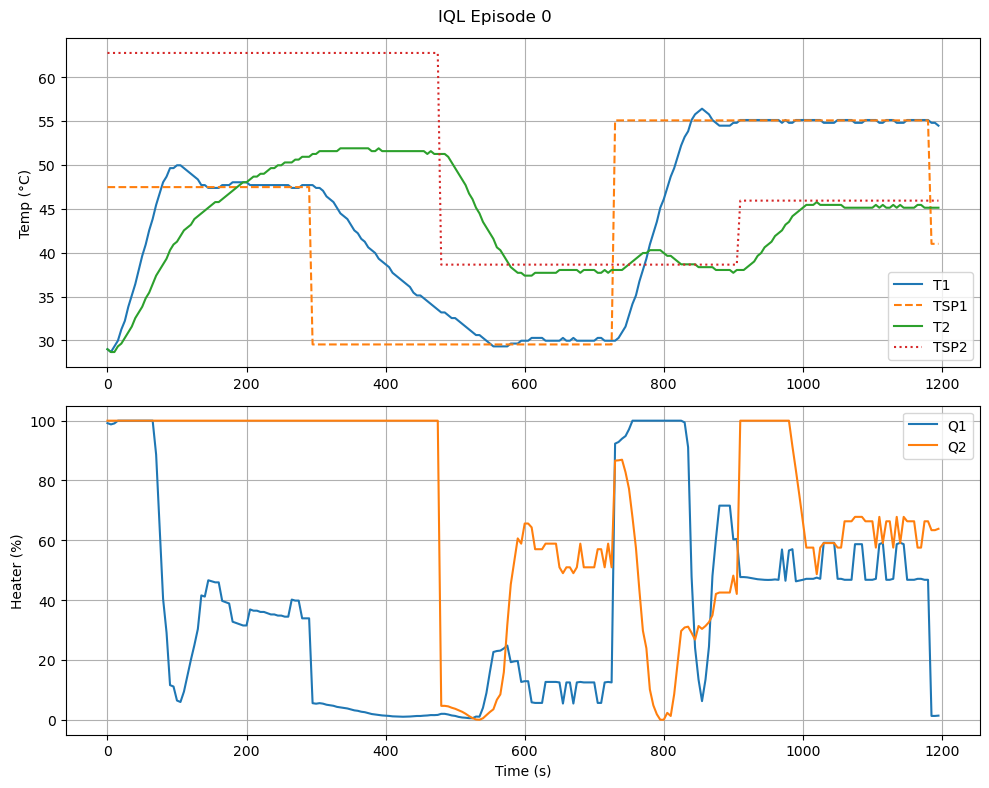

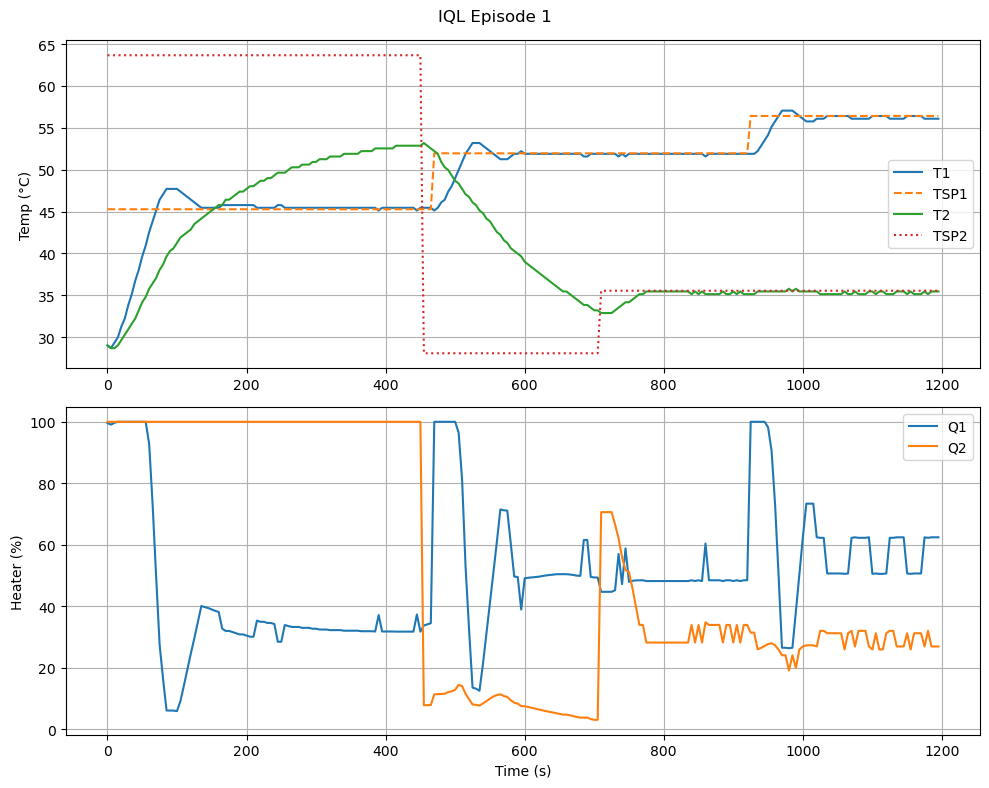

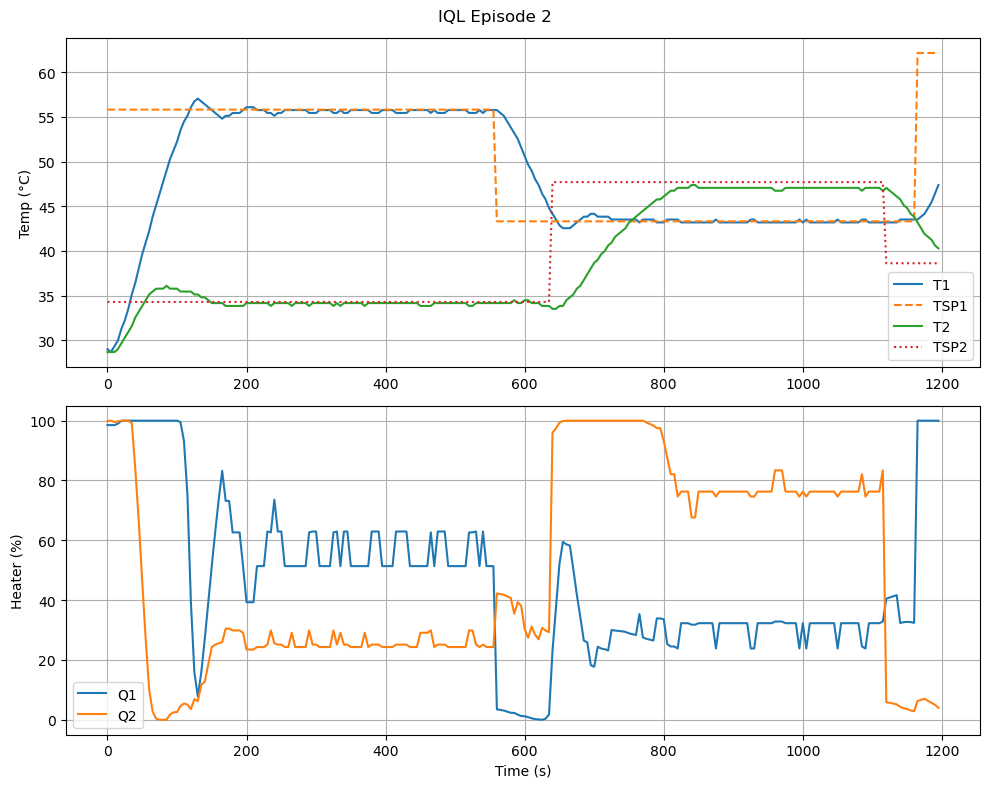

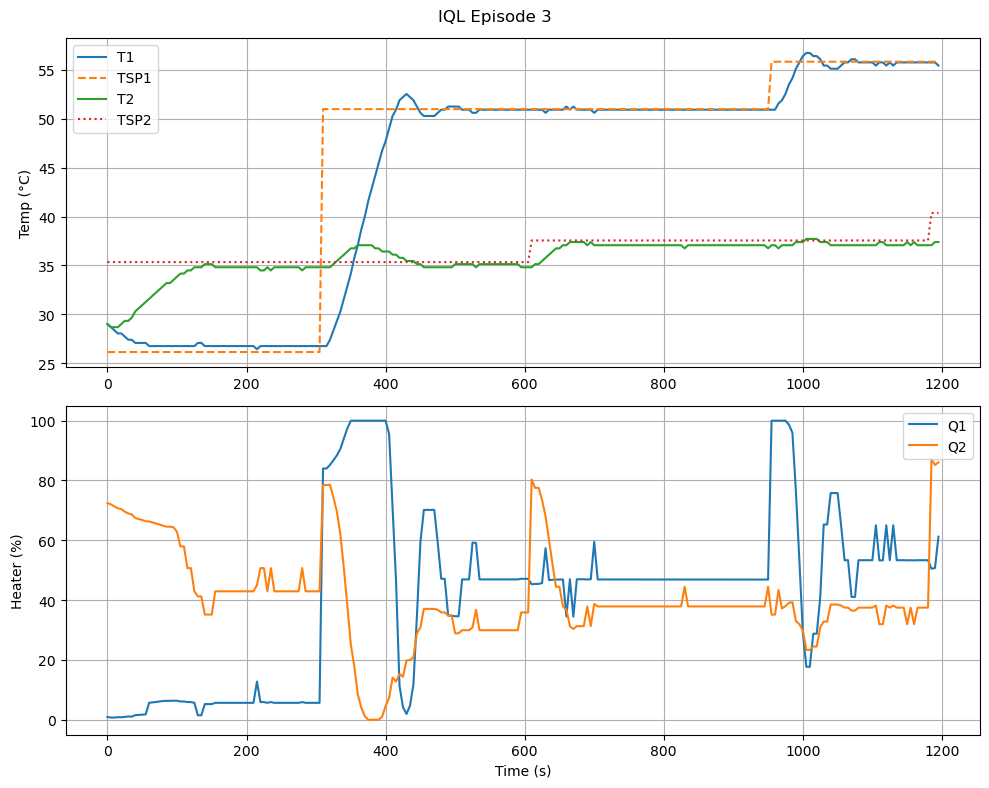

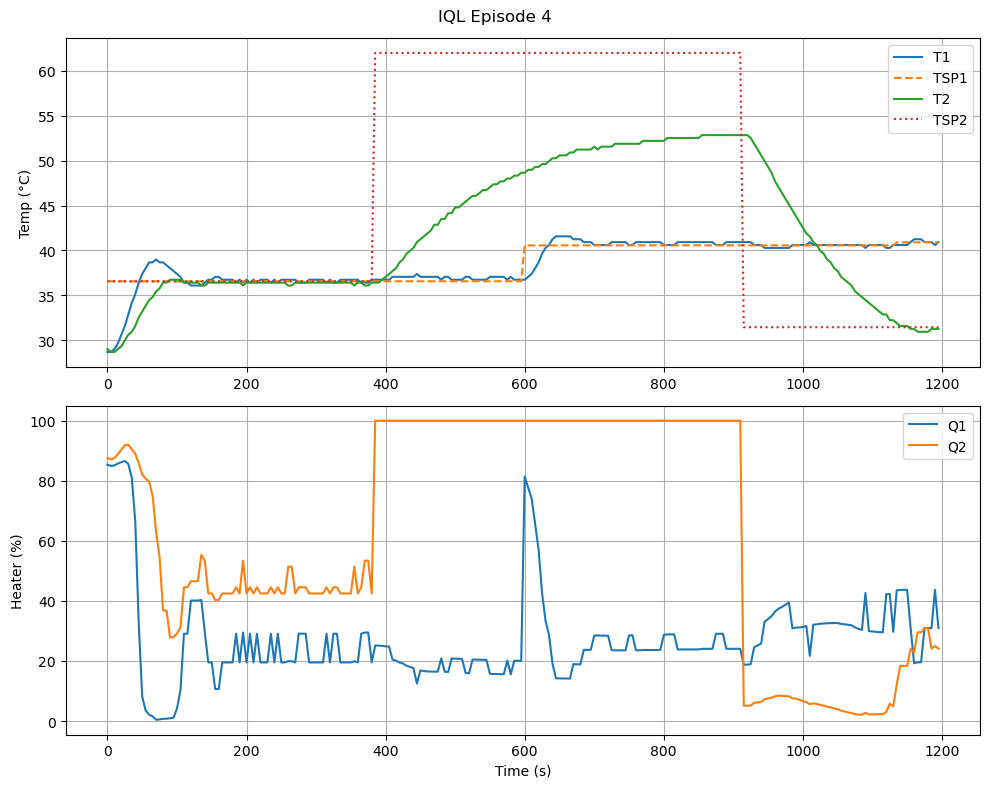

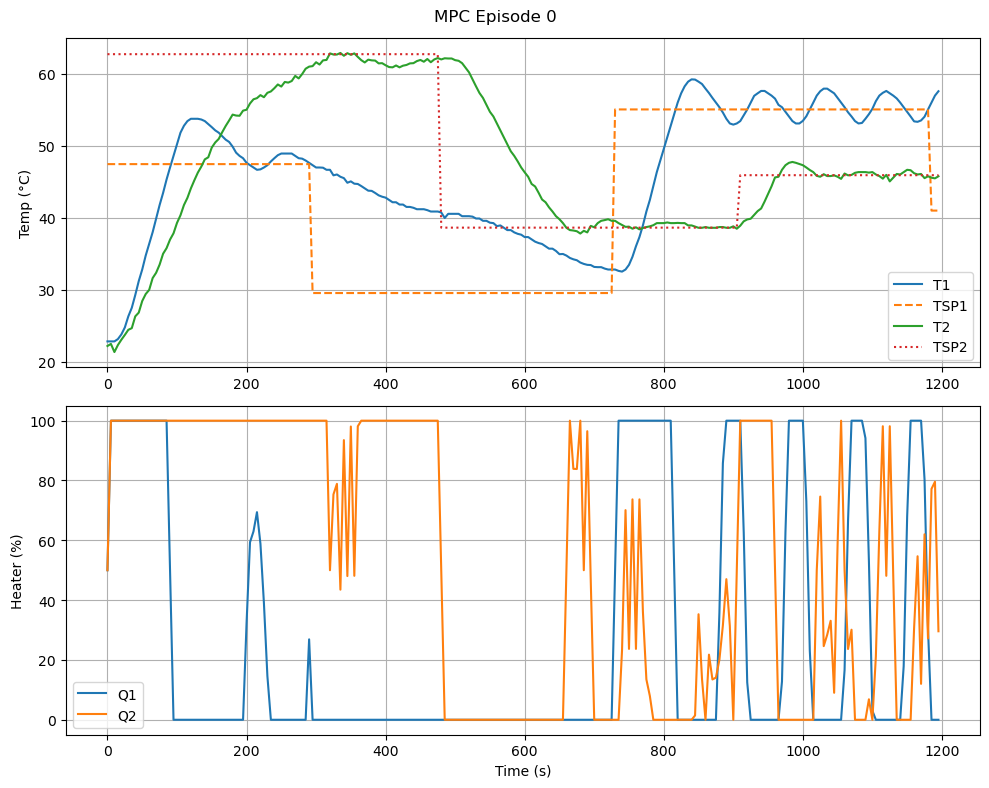

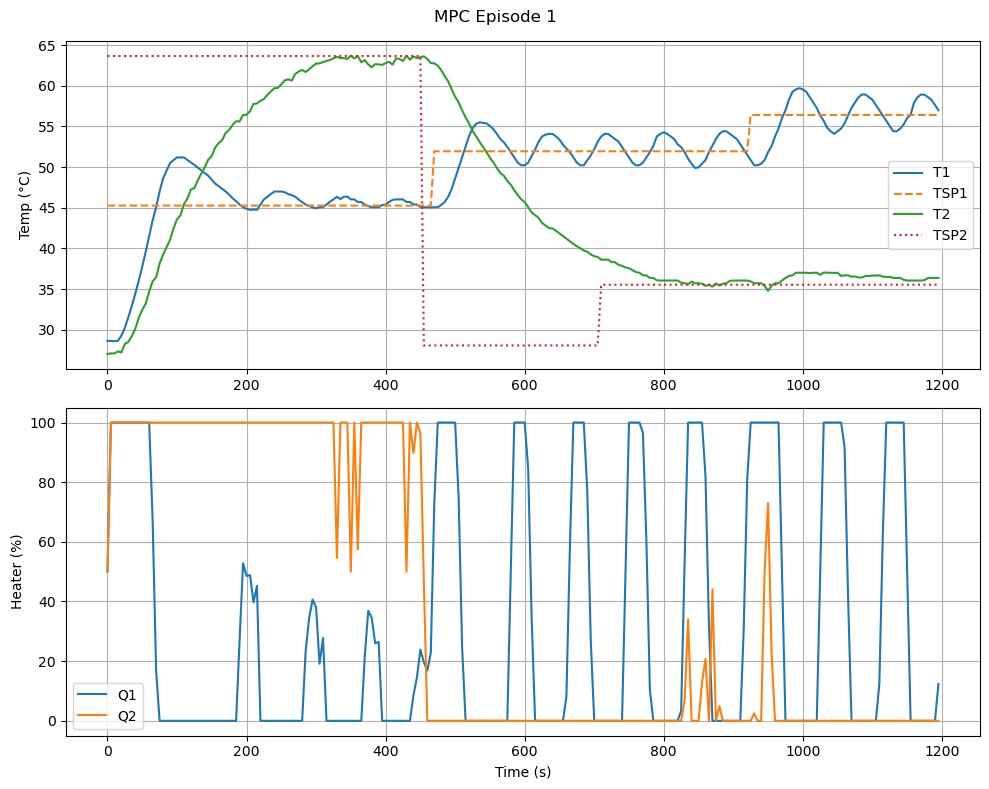

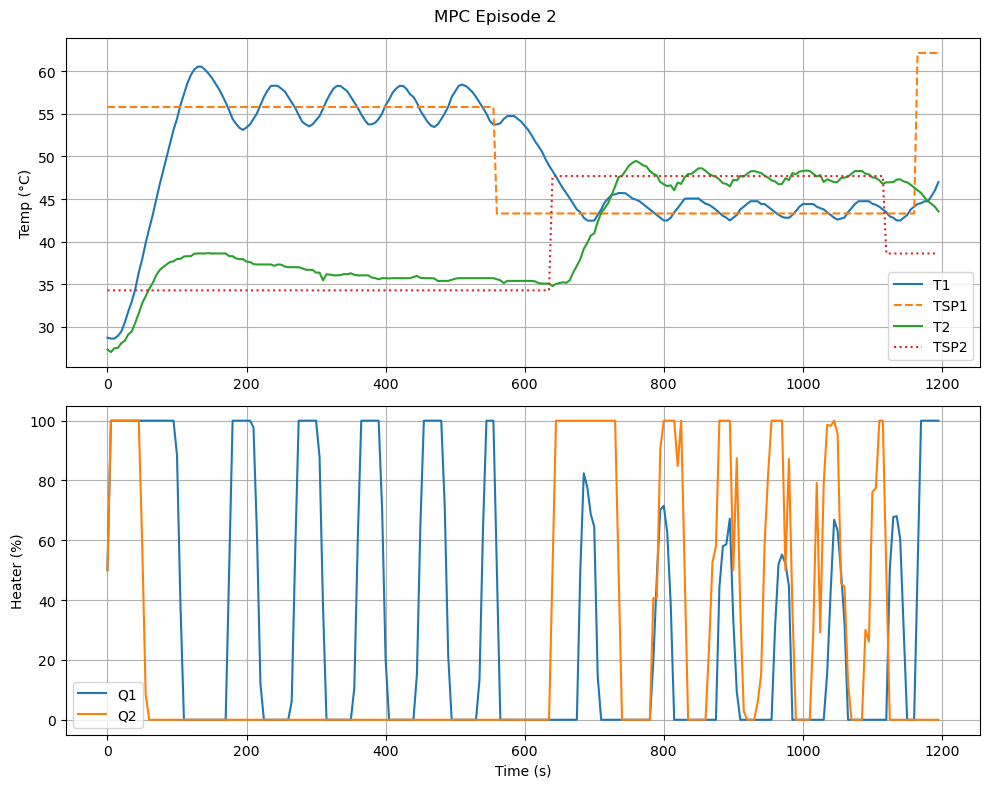

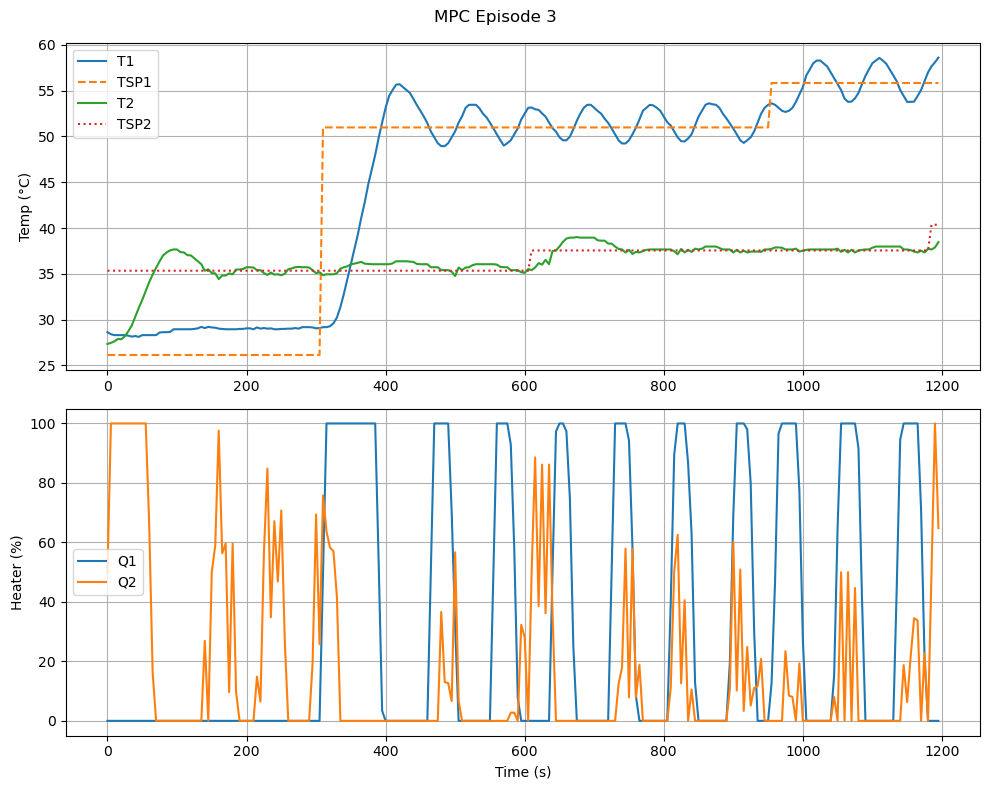

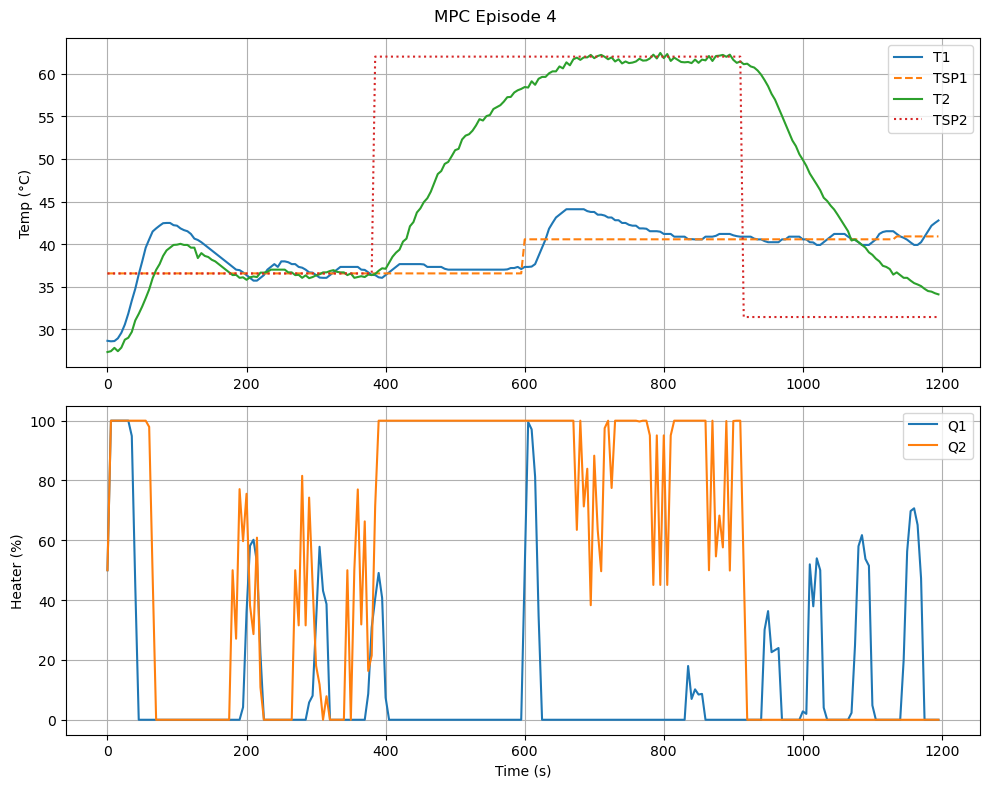

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
def plot_episode(csv_path: Path, title: str, save_path: Path, show: bool = False):
    df = pd.read_csv(csv_path)
    time = df["time"].values if "time" in df.columns else np.arange(len(df)) * 5.0
    T1, T2 = df["T1"].values, df["T2"].values
    Q1, Q2 = df["Q1"].values, df["Q2"].values
    TSP1, TSP2 = df["TSP1"].values, df["TSP2"].values

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    ax[0].plot(time, T1, label="T1")
    ax[0].plot(time, TSP1, "--", label="TSP1")
    ax[0].plot(time, T2, label="T2")
    ax[0].plot(time, TSP2, ":", label="TSP2")
    ax[0].legend(); ax[0].grid(); ax[0].set_ylabel("Temp (°C)")

    ax[1].plot(time, Q1, label="Q1")
    ax[1].plot(time, Q2, label="Q2")
    ax[1].legend(); ax[1].grid()
    ax[1].set_ylabel("Heater (%)"); ax[1].set_xlabel("Time (s)")

    plt.suptitle(title)
    plt.tight_layout()
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path)

    if show:
        plt.show()
    else:
        plt.close()


# 시각화 경로
save_dir = Path("C:/Users/User/TCLab/results_vis")

# IQL 시각화
for res in results_iql:
    ep = res["episode"]
    csv_path = Path(f"C:/Users/User/TCLab/inference_logs/sim_seed0_ep{ep}/rollout.csv")
    save_path = save_dir / f"ep{ep}_IQL.png"
    plot_episode(csv_path, title=f"IQL Episode {ep}", save_path=save_path, show=True)

for res in results_mpc:
    ep = res["episode"]
    csv_path = csv_files[ep]
    save_path = save_dir / f"ep{ep}_MPC.png"
    plot_episode(csv_path, title=f"MPC Episode {ep}", save_path=save_path, show=True)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tclab import setup
import time

# 시뮬레이터 설정
lab = setup(connected=False)
env = lab(synced=False)

# 시뮬레이션 파라미터
total_time = 600  # 10분 (초)
dt = 5.0          # 샘플 간격 (초)
steps = int(total_time / dt)

# 초기 설정
env.Q1(100)   # Q1 풀가동
env.Q2(0)     # Q2 끔
env._T1 = env._T2 = 29.0  # ambient 온도

# 데이터 저장용 배열
T1s = np.zeros(steps)
T2s = np.zeros(steps)
times = np.arange(steps) * dt

# 시뮬레이션 루프
for k in range(steps):
    env.update(t=k * dt)  # 시뮬레이터 시간 업데이트
    T1s[k], T2s[k] = env.T1, env.T2
    time.sleep(0.01)  # 너무 빠르게 도는 걸 방지 (가볍게 sleep)

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(times, T1s, label='T1')
plt.plot(times, T2s, label='T2')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Q1=100%, Q2=0% Heater Effect on T2")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
def simulate_fixed_heater(Q1_val=100, Q2_val=0, ambient=29.0, total_time=600, dt=5.0, label="Sim"):
    from tclab import setup
    import numpy as np
    import matplotlib.pyplot as plt
    import time

    steps = int(total_time / dt)
    times = np.arange(steps) * dt
    T1s, T2s = np.zeros(steps), np.zeros(steps)

    lab = setup(connected=False)
    env = lab(synced=False)
    env._T1 = env._T2 = ambient
    env.T_amb = ambient
    env.Q1(Q1_val); env.Q2(Q2_val)

    for k in range(steps):
        env.update(t=k * dt)
        T1s[k], T2s[k] = env.T1, env.T2
        time.sleep(0.01)

    plt.plot(times, T1s, label=f"T1 ({label})")
    plt.plot(times, T2s, label=f"T2 ({label})")
    return T1s, T2s


In [ ]:
# MPC와 IQL 조건 비교
T1_mpc, T2_mpc = simulate_fixed_heater(Q1_val=100, Q2_val=0, label="MPC fixed")
T1_iql, T2_iql = simulate_fixed_heater(Q1_val=100, Q2_val=0, label="IQL fixed")

# 그래프 출력
plt.title("Q1=100, Q2=0 일 때 T1, T2 변화 비교")
plt.xlabel("Time (s)"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()
